In [ ]:
# ====================================================================
#  KROK 1: Konfiguracja Środowiska

from google.colab import drive
drive.mount('/content/drive')

import os
import shutil
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# (do końcowej oceny)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Ustawienia dla powtarzalności wyników
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(f"Korzystam z GPU: {torch.cuda.get_device_name(0)}")
else:
    print("OSTRZEŻENIE: Korzystam z CPU. Trening będzie bardzo wolny.")
    print("Upewnij się, że w menu 'Środowisko wykonawcze' -> 'Zmień typ' wybrano GPU.")

Mounted at /content/drive
Korzystam z GPU: Tesla T4


In [ ]:
# ====================================================================
#  KROK 2: Konfiguracja Danych i Parametrów
# ====================================================================

# === 1. ŚCIEŻKI DO DANYCH NA GOOGLE DRIVE ===
TRAIN_SET_PATH = "/content/drive/MyDrive/PKG-Post-NAT-BRCA/Processed_BRCA_Data_TEST"
VAL_SET_PATH = "/content/drive/MyDrive/PKG-Post-NAT-BRCA/Processed_BRCA_Data_WALIDATION"
TEST_SET_PATH = "/content/drive/MyDrive/PKG-Post-NAT-BRCA/Processed_BRCA_Data_TEST_DS"

# === 2. ŚCIEŻKI LOKALNE  ===

LOCAL_BASE_DIR = "/content/final_dataset"
LOCAL_TRAIN_DIR = os.path.join(LOCAL_BASE_DIR, "train")
LOCAL_VAL_DIR = os.path.join(LOCAL_BASE_DIR, "val")
LOCAL_TEST_DIR = os.path.join(LOCAL_BASE_DIR, "test")

# === 3. PARAMETRY HIPERNETYCZNE ===
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
NUM_EPOCHS = 40
EARLY_STOPPING_PATIENCE = 7
BALANCE_TRAIN = True

In [ ]:
# ====================================================================
#  KROK 3: Przygotowanie Danych (Kopiowanie i Balansowanie)
# ====================================================================

def find_files_recursive(scan_dir_path):
    """Pomocnicza funkcja do znajdowania ścieżek do kafelków."""
    healthy_files = []
    tumor_files = []

    if not os.path.exists(scan_dir_path):
        print(f"Ostrzeżenie: Folder {scan_dir_path} nie istnieje.")
        return healthy_files, tumor_files

    for scan_name in os.listdir(scan_dir_path):
        scan_path = os.path.join(scan_dir_path, scan_name)
        if not os.path.isdir(scan_path):
            continue

        healthy_path = os.path.join(scan_path, "healthy")
        tumor_path = os.path.join(scan_path, "tumor")

        if os.path.exists(healthy_path):
            for fname in os.listdir(healthy_path):
                healthy_files.append(os.path.join(healthy_path, fname))
        if os.path.exists(tumor_path):
            for fname in os.listdir(tumor_path):
                tumor_files.append(os.path.join(tumor_path, fname))

    return healthy_files, tumor_files

def copy_files(file_list, target_dir):
    """Pomocnicza funkcja do kopiowania plików."""
    os.makedirs(target_dir, exist_ok=True)
    for f_path in file_list:
        shutil.copy(f_path, target_dir)

print(f"Czyszczę stare dane (jeśli istnieją) w {LOCAL_BASE_DIR}...")
if os.path.exists(LOCAL_BASE_DIR):
    shutil.rmtree(LOCAL_BASE_DIR)

print("Rozpoczynam kopiowanie i balansowanie. To potrwa kilka minut...")

# --- 1. PRZETWARZANIE ZBIORU TRENINGOWEGO ---
print(f"\nPrzetwarzam zbiór TRENINGOWY z: {TRAIN_SET_PATH}")
train_h_files, train_t_files = find_files_recursive(TRAIN_SET_PATH)
n_healthy = len(train_h_files)
n_tumor = len(train_t_files)
print(f"Znaleziono {n_healthy} healthy | {n_tumor} tumor.")

if BALANCE_TRAIN:
    # Balansowanie (Undersampling)
    n_to_sample = min(n_healthy, n_tumor)
    if n_to_sample == 0:
        print("BŁĄD: Brak plików w zbiorze treningowym.")
    else:
        print(f"Stosuję Undersampling: Wybieram {n_to_sample} plików z każdej klasy.")
        final_train_h = random.sample(train_h_files, n_to_sample)
        final_train_t = random.sample(train_t_files, n_to_sample)
else:
    # Bez balansowania – używamy wszystkich danych
    print("BALANCE_TRAIN = False -> używam wszystkich danych treningowych bez undersamplingu.")
    final_train_h = train_h_files
    final_train_t = train_t_files

# Kopiowanie danych treningowych
copy_files(final_train_h, os.path.join(LOCAL_TRAIN_DIR, "healthy"))
copy_files(final_train_t, os.path.join(LOCAL_TRAIN_DIR, "tumor"))
print("Zakończono kopiowanie zbioru treningowego.")

# --- 2. PRZETWARZANIE ZBIORU WALIDACYJNEGO (bez balansowania) ---
print(f"\nPrzetwarzam zbiór WALIDACYJNY z: {VAL_SET_PATH}")
val_h_files, val_t_files = find_files_recursive(VAL_SET_PATH)
print(f"Znaleziono {len(val_h_files)} healthy | {len(val_t_files)} tumor.")
copy_files(val_h_files, os.path.join(LOCAL_VAL_DIR, "healthy"))
copy_files(val_t_files, os.path.join(LOCAL_VAL_DIR, "tumor"))
print("Zakończono kopiowanie zbioru walidacyjnego.")

# --- 3. PRZETWARZANIE ZBIORU TESTOWEGO (bez balansowania) ---
print(f"\nPrzetwarzam zbiór TESTOWY z: {TEST_SET_PATH}")
test_h_files, test_t_files = find_files_recursive(TEST_SET_PATH)
print(f"Znaleziono {len(test_h_files)} healthy | {len(test_t_files)} tumor.")
copy_files(test_h_files, os.path.join(LOCAL_TEST_DIR, "healthy"))
copy_files(test_t_files, os.path.join(LOCAL_TEST_DIR, "tumor"))
print("Zakończono kopiowanie zbioru testowego.")

print("\n--- PODSUMOWANIE DANYCH LOKALNYCH ---")
print(f"Trening Healthy: {len(os.listdir(os.path.join(LOCAL_TRAIN_DIR, 'healthy')))} plików")
print(f"Trening Tumor:   {len(os.listdir(os.path.join(LOCAL_TRAIN_DIR, 'tumor')))} plików")
print(f"Walid. Healthy:  {len(os.listdir(os.path.join(LOCAL_VAL_DIR, 'healthy')))} plików")
print(f"Walid. Tumor:    {len(os.listdir(os.path.join(LOCAL_VAL_DIR, 'tumor')))} plików")
print(f"Test Healthy:    {len(os.listdir(os.path.join(LOCAL_TEST_DIR, 'healthy')))} plików")
print(f"Test Tumor:      {len(os.listdir(os.path.join(LOCAL_TEST_DIR, 'tumor')))} plików")


Czyszczę stare dane (jeśli istnieją) w /content/final_dataset...
Rozpoczynam kopiowanie i balansowanie. To potrwa kilka minut...

Przetwarzam zbiór TRENINGOWY z: /content/drive/MyDrive/PKG-Post-NAT-BRCA/Processed_BRCA_Data_TEST
Znaleziono 1577 healthy | 3536 tumor.
Stosuję Undersampling: Wybieram 1577 plików z każdej klasy.
Zakończono kopiowanie zbioru treningowego.

Przetwarzam zbiór WALIDACYJNY z: /content/drive/MyDrive/PKG-Post-NAT-BRCA/Processed_BRCA_Data_WALIDATION
Znaleziono 892 healthy | 1133 tumor.
Zakończono kopiowanie zbioru walidacyjnego.

Przetwarzam zbiór TESTOWY z: /content/drive/MyDrive/PKG-Post-NAT-BRCA/Processed_BRCA_Data_TEST_DS
Znaleziono 796 healthy | 2057 tumor.
Zakończono kopiowanie zbioru testowego.

--- PODSUMOWANIE DANYCH LOKALNYCH ---
Trening Healthy: 1577 plików
Trening Tumor:   1577 plików
Walid. Healthy:  892 plików
Walid. Tumor:    1133 plików
Test Healthy:    796 plików
Test Tumor:      2057 plików


In [ ]:
# ====================================================================
#  KROK 4: Definicja Augmentacji i DataLoaderów (Wersja ulepszona)
# ====================================================================

input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(90),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size + 32),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(LOCAL_TRAIN_DIR, data_transforms['train']),
    'val': datasets.ImageFolder(LOCAL_VAL_DIR, data_transforms['val']),
    'test': datasets.ImageFolder(LOCAL_TEST_DIR, data_transforms['val'])
}

num_workers = 4 if torch.cuda.is_available() else 2

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=num_workers, pin_memory=True),
    'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE,
                      shuffle=False, num_workers=num_workers, pin_memory=True),
    'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE,
                       shuffle=False, num_workers=num_workers, pin_memory=True)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print("Gotowe DataLoadery (z augmentacją dla treningu).")
print(f"Klasy: {class_names}")
print(f"Rozmiary zbiorów: {dataset_sizes}")


Gotowe DataLoadery (z augmentacją dla treningu).
Klasy: ['healthy', 'tumor']
Rozmiary zbiorów: {'train': 3154, 'val': 2025, 'test': 2853}


In [ ]:
# ====================================================================
#  KROK 5: Definicja Modelu (Wersja 5.0 – pełne fine-tuning ResNet18)
# ====================================================================

#  ResNet18 z wagami z ImageNet
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# ---- 1. ODMRAŻAMY WSZYSTKIE WARSTWY ----
for param in model.parameters():
    param.requires_grad = True

# ---- 2. Nowa  (fc) z dropoutem ----
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, len(class_names))
)

model = model.to(device)

print("Model ResNet18 zdefiniowany (pełne fine-tuning).")
print("Struktura nowej 'głowy' (fc):")
print(model.fc)

# ---- 3. Funkcja straty ----
criterion = nn.CrossEntropyLoss()

# ---- 4. Discriminative learning rates ----
# Założenie: LEARNING_RATE z komórki 2, np. 1e-4
head_lr = LEARNING_RATE
high_lr = LEARNING_RATE / 10
low_lr  = LEARNING_RATE / 100

params_head = list(model.fc.parameters())
params_high = list(model.layer3.parameters()) + list(model.layer4.parameters())
params_low  = (
    list(model.conv1.parameters()) +
    list(model.bn1.parameters()) +
    list(model.layer1.parameters()) +
    list(model.layer2.parameters())
)

params_to_update = [
    {'params': params_head, 'lr': head_lr},
    {'params': params_high, 'lr': high_lr},
    {'params': params_low,  'lr': low_lr}
]

optimizer = optim.Adam(params_to_update)

print("Zdefiniowano 3 grupy parametrów z różnymi LR:")
print(f"  Głowa (fc):          lr = {head_lr}")
print(f"  Wyższe warstwy:      lr = {high_lr}")
print(f"  Niższe warstwy:      lr = {low_lr}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 94.6MB/s]


Model ResNet18 zdefiniowany (pełne fine-tuning).
Struktura nowej 'głowy' (fc):
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=512, out_features=2, bias=True)
)
Zdefiniowano 3 grupy parametrów z różnymi LR:
  Głowa (fc):          lr = 0.0001
  Wyższe warstwy:      lr = 1e-05
  Niższe warstwy:      lr = 1e-06


In [ ]:
# ====================================================================
#  KROK 6: Główna Pętla Treningowa (z LR scheduler + early stopping)
# ====================================================================

import copy

print("Rozpoczynam trening...")
start_time = time.time()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
best_epoch = 0

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# Scheduler: zmniejsza LR, gdy val_acc przestaje się poprawiać
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,

)

epochs_no_improve = 0
stop_training = False

for epoch in range(NUM_EPOCHS):
    if stop_training:
        break

    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 20)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase.title()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc.item())
        else:
            history['val_loss'].append(epoch_loss)
            history['val_acc'].append(epoch_acc.item())

            # Scheduler patrzy na accuracy walidacyjne
            scheduler.step(epoch_acc)

            for i, param_group in enumerate(optimizer.param_groups):
                print(f"  -> LR group {i}: {param_group['lr']}")

            # Sprawdzamy, czy to najlepszy model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch + 1
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0

                save_path = f"/content/drive/MyDrive/resnet_train/final_best_model_epoch_{epoch+1}.pth"
                torch.save(model.state_dict(), save_path)
                print(f"====> Nowy najlepszy model zapisany w: {save_path} (Acc: {best_acc:.4f})")
            else:
                epochs_no_improve += 1
                print(f"Brak poprawy dokładności walidacji od {epochs_no_improve} epok.")

                if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
                    print(f"\nEARLY STOPPING: brak poprawy przez {EARLY_STOPPING_PATIENCE} epok.")
                    stop_training = True
                    break

time_elapsed = time.time() - start_time
print(f'\nTrening zakończony w {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
print(f'Najlepsza celność walidacyjna: {best_acc:.4f} (epoka {best_epoch})')

# Wczytaj najlepsze wagi do modelu
model.load_state_dict(best_model_wts)


Rozpoczynam trening...

Epoch 1/40
--------------------
Train Loss: 0.7433 Acc: 0.5672
Val Loss: 0.6169 Acc: 0.6711
  -> LR group 0: 0.0001
  -> LR group 1: 1e-05
  -> LR group 2: 1e-06
====> Nowy najlepszy model zapisany w: /content/drive/MyDrive/resnet_train/final_best_model_epoch_1.pth (Acc: 0.6711)

Epoch 2/40
--------------------
Train Loss: 0.6163 Acc: 0.6665
Val Loss: 0.5264 Acc: 0.7526
  -> LR group 0: 0.0001
  -> LR group 1: 1e-05
  -> LR group 2: 1e-06
====> Nowy najlepszy model zapisany w: /content/drive/MyDrive/resnet_train/final_best_model_epoch_2.pth (Acc: 0.7526)

Epoch 3/40
--------------------
Train Loss: 0.5624 Acc: 0.7175
Val Loss: 0.5012 Acc: 0.7590
  -> LR group 0: 0.0001
  -> LR group 1: 1e-05
  -> LR group 2: 1e-06
====> Nowy najlepszy model zapisany w: /content/drive/MyDrive/resnet_train/final_best_model_epoch_3.pth (Acc: 0.7590)

Epoch 4/40
--------------------
Train Loss: 0.5172 Acc: 0.7422
Val Loss: 0.4854 Acc: 0.7842
  -> LR group 0: 0.0001
  -> LR group 1: 

<All keys matched successfully>

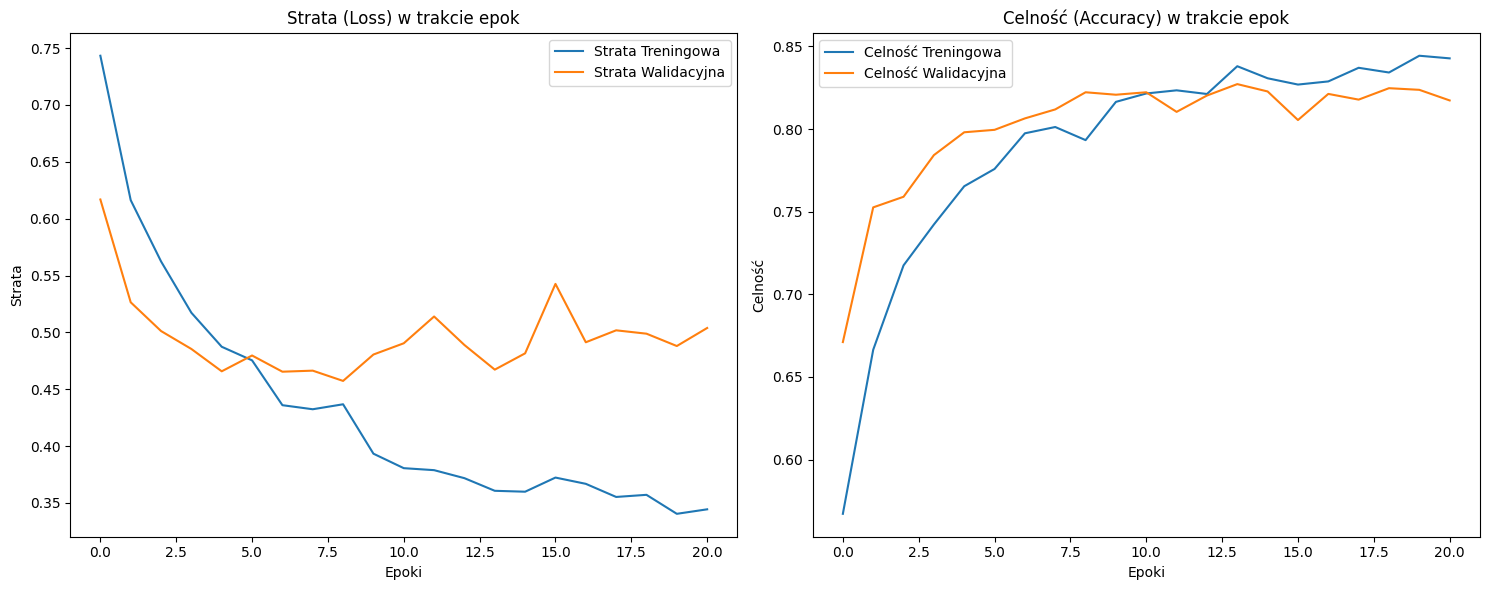

In [ ]:
# ====================================================================
#  KROK 7: Wizualizacja Wyników Treningu
# ====================================================================

plt.figure(figsize=(15, 6))

# Wykres Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Strata Treningowa')
plt.plot(history['val_loss'], label='Strata Walidacyjna')
plt.title('Strata (Loss) w trakcie epok')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

# Wykres Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Celność Treningowa')
plt.plot(history['val_acc'], label='Celność Walidacyjna')
plt.title('Celność (Accuracy) w trakcie epok')
plt.xlabel('Epoki')
plt.ylabel('Celność')
plt.legend()

plt.tight_layout()
plt.show()


Rozpoczynam ostateczną ewaluację na zbiorze TESTOWYM...
Pomyślnie wczytano najlepszy model z: /content/drive/MyDrive/resnet_train/final_best_model_epoch_14.pth

--- RAPORT KLASYFIKACJI (Zbiór Testowy) ---
              precision    recall  f1-score   support

     healthy       0.84      0.90      0.87       796
       tumor       0.96      0.93      0.95      2057

    accuracy                           0.92      2853
   macro avg       0.90      0.92      0.91      2853
weighted avg       0.93      0.92      0.93      2853


--- MACIERZ POMYŁEK (Confusion Matrix) ---


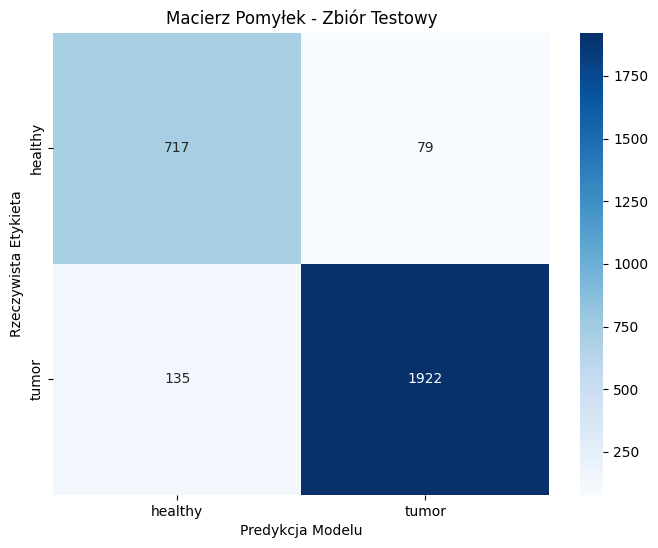

In [ ]:
# ====================================================================
#  KROK 8: Ostateczna Ewaluacja na Zbiorze Testowym
# ====================================================================
print("\nRozpoczynam ostateczną ewaluację na zbiorze TESTOWYM...")

# Wczytaj najlepszy model zapisany na dysku
# (Upewnij się, że ścieżka jest poprawna, jeśli zmieniłeś nazwę)
best_model_path = f"/content/drive/MyDrive/resnet_train/final_best_model_epoch_{history['val_acc'].index(max(history['val_acc']))+1}.pth"
try:
    model.load_state_dict(torch.load(best_model_path))
    print(f"Pomyślnie wczytano najlepszy model z: {best_model_path}")
except Exception as e:
    print(f"Błąd wczytywania modelu, używam modelu z pamięci. Błąd: {e}")
    # Jeśli wystąpi błąd, model i tak jest w pamięci po pętli treningowej

model.eval() # Ustaw model w tryb ewaluacji

all_preds = []
all_labels = []

with torch.no_grad(): # Wyłącz obliczanie gradientów
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Przenieś na CPU i zapisz do list
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n--- RAPORT KLASYFIKACJI (Zbiór Testowy) ---")
# Generuje precyzję (precision), pełność (recall), f1-score
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

print("\n--- MACIERZ POMYŁEK (Confusion Matrix) ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Macierz Pomyłek - Zbiór Testowy')
plt.xlabel('Predykcja Modelu')
plt.ylabel('Rzeczywista Etykieta')
plt.show()